In [64]:
import numpy as np
from obspy.geodetics.base import gps2dist_azimuth, kilometer2degrees
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import sw4FileFunctions as sff
from datetime import datetime, timedelta

# Event and Station locations #ok

In [65]:
# Read events in the catalog
startdate = datetime.strptime("20100504", "%Y%m%d")
enddate = datetime.strptime("20100520", "%Y%m%d")
templates=pd.read_csv('./EQloc_001_0.1_3_S.txt_withdates', index_col=0)
templates=templates[(templates['residual']<0.5)]
templates['OT'] = pd.to_datetime(templates['OT']) # Formatting 'OT' column as datetime
templates = templates[(templates['OT'] >= startdate)
                    & (templates['OT'] < enddate)
                    & (templates['residual'] < 0.1)]
templates = templates.drop(columns=['dates', 'residual', 'starttime','dt'])
templates.reset_index(inplace=True, drop=True)
templates.index.name = 'Index'
templates = templates.sort_values(by='N', ascending=False)
templates = templates[0:20+1]
templates['template'] = "template_" + templates.index.astype(str)
print(templates)

                           OT         lon        lat  depth  N       template
Index                                                                        
1564  2010-05-17 13:31:47.598 -123.790894  48.888768  -29.0  5  template_1564
1619  2010-05-17 15:19:05.317 -123.993707  48.546921  -15.0  5  template_1619
1747  2010-05-17 18:01:11.271 -123.641357  48.699949  -53.0  5  template_1747
1646  2010-05-17 15:55:55.772 -123.601829  48.286383  -27.0  5  template_1646
609   2010-05-10 17:03:38.006 -124.157480  48.708269  -46.0  4   template_609
1801  2010-05-17 18:56:03.787 -123.395902  48.843286   -1.0  4  template_1801
1936  2010-05-17 21:42:25.040 -123.489459  49.185120  -58.0  4  template_1936
110   2010-05-05 19:56:52.799 -123.544309  49.185230  -24.0  4   template_110
695   2010-05-10 20:16:39.368 -123.966016  48.403142  -35.0  4   template_695
1627  2010-05-17 15:31:54.113 -123.736337  49.005633  -44.0  4  template_1627
1939  2010-05-17 21:48:05.244 -123.489647  49.149165   -2.0  4  

In [66]:
eventLocs = templates[['lon', 'lat', 'depth','template']]
# Multiple events? (if you only have one set this to false so that we dont try to plot those)
multipleEvents=True
# Pick Which Event to Model, or just put your event here
event=eventLocs.loc[1940]
# In addition to Event Locations Also feed me the maximum frequency you want to model
freqMax=4 #Hz
print(event)

lon           -123.532676
lat             48.708784
depth               -33.0
template    template_1940
Name: 1940, dtype: object


In [67]:
print(eventLocs)

              lon        lat  depth       template
Index                                             
1564  -123.790894  48.888768  -29.0  template_1564
1619  -123.993707  48.546921  -15.0  template_1619
1747  -123.641357  48.699949  -53.0  template_1747
1646  -123.601829  48.286383  -27.0  template_1646
609   -124.157480  48.708269  -46.0   template_609
1801  -123.395902  48.843286   -1.0  template_1801
1936  -123.489459  49.185120  -58.0  template_1936
110   -123.544309  49.185230  -24.0   template_110
695   -123.966016  48.403142  -35.0   template_695
1627  -123.736337  49.005633  -44.0  template_1627
1939  -123.489647  49.149165   -2.0  template_1939
1630  -123.383071  48.735373  -44.0  template_1630
1807  -123.423549  48.780442  -41.0  template_1807
1940  -123.532676  48.708784  -33.0  template_1940
1804  -123.722791  48.789890  -42.0  template_1804
1634  -123.790843  48.825843    0.0  template_1634
1945  -123.682062  48.726948  -20.0  template_1945
1800  -123.654528  48.915703   

In [68]:
print(event)

lon           -123.532676
lat             48.708784
depth               -33.0
template    template_1940
Name: 1940, dtype: object


In [69]:
stas=pd.read_csv('./stations.csv', usecols=[1, 2, 3, 4],
                    names=['name', 'lat', 'lon', 'elev'], header=0, delimiter='|')

In [70]:
print(stas)

    name        lat         lon   elev
0   BPCB  48.923600 -123.704500   31.0
1   GLBC  48.396000 -123.636300  100.0
2   JRBC  48.395700 -123.960000   20.0
3   LCBC  48.483400 -124.261900  100.0
4   MGCB  48.631700 -123.680800  236.0
5   PHYB  49.082800 -123.843100   39.0
6   SHDB  48.797000 -123.636000   55.0
7   SHVB  48.472300 -123.636000   69.0
8   SOKB  48.394700 -123.673100   45.0
9   TWBB  48.584600 -124.092000  122.0
10   LZB  48.612200 -123.824000  794.0
11  NLLB  49.227100 -123.988200  199.0
12   PFB  48.574700 -124.454100  449.0
13   PGC  48.649800 -123.452100   12.0
14   SNB  48.775100 -123.172300  402.0
15   VGZ  48.413100 -123.325100   67.0
16  YOUB  48.901000 -124.261800  771.0
17  GOWB  48.736900 -123.184800   29.0
18  KLNB  48.661100 -123.570600    0.0
19  SILB  48.602000 -123.281500   76.0
20  SSIB  48.755800 -123.387500   12.0
21  TSJB  48.601300 -123.988500  378.0
22  TWGB  48.607600 -124.255800  127.0
23  TWKB  48.644800 -123.733200  128.0
24  B009  48.648670 -123.

In [71]:
# Choose subset of stations
sta = stas[stas['name'] == 'LZB']
sta

,name,lat,lon,elev
10,LZB,48.6122,-123.824,794.0


# Plot Events and Stations #ok

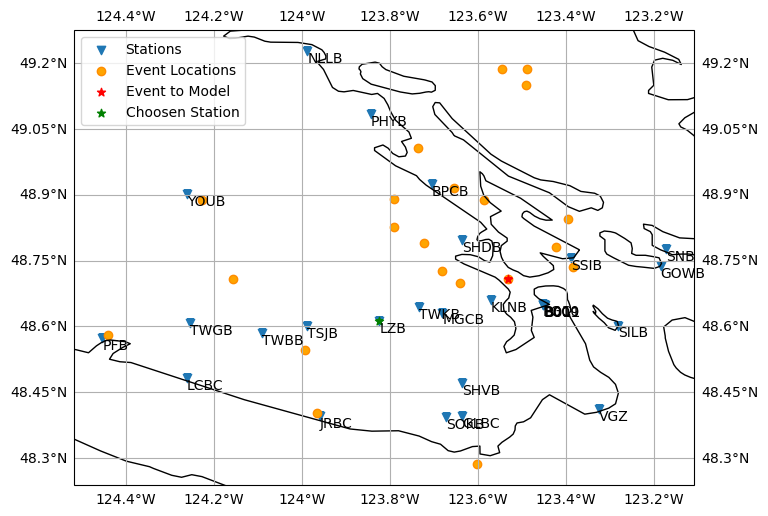

In [79]:
# Kate code for the plot
fig=plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(stas['lon'],stas['lat'],marker='v',label='Stations')
# Add station labels
[plt.text(i, j, f'{name}',va='top',ha='left') for (i, j,name) in zip(stas['lon'],stas['lat'],stas['name'])]
if multipleEvents:
    plt.scatter(eventLocs['lon'],eventLocs['lat'],marker='o',edgecolors='darkorange',facecolors='orange',label='Event Locations')

# Scatter plot for the event to model
plt.scatter(event['lon'], event['lat'], marker='*', facecolors='red', label="Event to Model")
#plt.text(event['lon'], event['lat'], f"({event['lat']:.3f},{event['lon']:.3f})")
plt.scatter(sta['lon'],sta['lat'],marker='*',facecolors='green',label="Choosen Station")
ax.legend()

ax.coastlines()
# ax.set_axis_on()
# ax.get_xticks(minor=True)
gl = ax.gridlines(draw_labels=True)
# ax.minorticks_on()
# gl.top_labels = False
# gl.right_labels = False
Plotlims=ax.get_extent()
plt.show()

In [73]:
# These values are roughly the rectangle that encompasses all of our points plus a little buffer
lonMin_ini, lonMax_ini, latMin_ini, latMax_ini=Plotlims
# setup points for box for domain from above with only event and stations
x_ini=[Plotlims[0],Plotlims[1],Plotlims[1],Plotlims[0],Plotlims[0]]
y_ini=[Plotlims[2],Plotlims[2],Plotlims[3],Plotlims[3],Plotlims[2]]
print(lonMin_ini, lonMax_ini, latMin_ini, latMax_ini)

-124.51818999999999 -123.10821000000001 48.23934715 49.27413585


# Velocity Model Stuff

In [74]:
# Load velocity model data
vmod=pd.read_csv('Savard_VpVs.txt', sep='\s+',header=None, names=['lon', 'lat', 'depth', 'vp', 'vs', 'DWS'])
print(vmod)

              lon        lat  depth        vp        vs  DWS
0     -126.672510  46.951514    0.0  4.956299  2.864755  0.0
1     -126.675741  47.077409    0.0  4.966347  2.870762  0.0
2     -126.678979  47.203304    0.0  4.976305  2.876411  0.0
3     -126.681999  47.320203    0.0  4.968136  2.871618  0.0
4     -126.685262  47.446098    0.0  4.957817  2.865878  0.0
...           ...        ...    ...       ...       ...  ...
36987 -120.554069  50.494531   93.0  8.245674  4.766323  0.0
36988 -120.549634  50.620422   93.0  8.249911  4.768947  0.0
36989 -120.545500  50.737325   93.0  8.257427  4.772954  0.0
36990 -120.541032  50.863220   93.0  8.261029  4.774880  0.0
36991 -120.536556  50.989115   93.0  8.264282  4.776913  0.0

[36992 rows x 6 columns]


In [78]:
# Made to save memory by having a smaller bit of the coordinates
vmod_subset=vmod[(vmod['lat']>=latMin_ini)&(vmod['lat']<=latMax_ini)&(vmod['lon']<=lonMax_ini)&(vmod['lon']>=lonMin_ini)]
print(vmod_subset)

              lon        lat  depth        vp        vs      DWS
419   -124.487386  48.300378    0.0  3.399979  1.965315     0.95
420   -124.487988  48.426274    0.0  4.170433  2.434671     0.00
421   -124.488550  48.543172    0.0  5.085475  3.046571  1091.81
422   -124.489160  48.669067    0.0  5.735728  3.433735   395.36
423   -124.489722  48.785970    0.0  5.955731  3.466257     2.39
...           ...        ...    ...       ...       ...      ...
36497 -123.211003  48.785970   93.0  8.282111  4.787434     0.00
36498 -123.210083  48.902873   93.0  8.300007  4.797538     0.00
36499 -123.209098  49.028764   93.0  8.312159  4.804675     0.00
36500 -123.208179  49.145667   93.0  8.315099  4.806439     0.00
36501 -123.207186  49.271562   93.0  8.314213  4.805908     0.00

[2304 rows x 6 columns]


In [6]:
#vr=pd.read_csv('VelocityInfo/out.vr_release', sep='\s+',header=None, names=['lon','lat','depth','vp/vs'])
#vs=np.round(vmod['vp']/vr['vp/vs'],3) # compute vs and round 
#vmod.insert(4,'vs',vs)

In [77]:
# Assign some values from the velocity model for later
# We need Vs min for computing the desired resolution for the domain
# We need the max Vp/Vs ratio, becuase the number of points per wavelength you need for good resolution is higher for high Vp/Vs
vs_min=vmod_subset['vs'].min()
VpVs_max=vr['vp/vs'].max()
ind=vr.index[vr['vp/vs']==vr['vp/vs'].max()]
Vp_fromVpVsmax=vmod['vp'][ind]
Vs_fromVpVsmax=vmod['vs'][ind]
val=(Vs_fromVpVsmax**2)/(Vp_fromVpVsmax**2-2*Vs_fromVpVsmax**2)
depth_max=vmod['depth'].max()
val

NameError: name 'vr' is not defined

If val here was <0.1 then we'd have to worry about needing wayyyyy more points per wavelength (like 40 instead of 6-10), but we are okay here

See ref: H.-O. Kreiss and N.A. Petersson. Boundary estimates for the elastic wave equation in almost incompressible materials. SIAM J. Numer. Anal., 50:1556–1580, 2012.

# Plot bounds of Velocity Model with station locations

In [16]:
# Get bounds of velocity model
vmod.sort_values(['lat', 'lon']).reindex()
# get lats and lons for our corners of the vmodel
lon_llc=vmod[vmod['lat']==vmod['lat'].min()]['lon'].min()
lon_lrc=vmod[vmod['lat']==vmod['lat'].min()]['lon'].max()
lon_urc=vmod[vmod['lat']==vmod['lat'].max()]['lon'].max()
lon_ulc=vmod[vmod['lat']==vmod['lat'].max()]['lon'].min()

lat_llc=vmod['lat'].min()
lat_lrc=vmod['lat'].min()
lat_urc=vmod['lat'].max()
lat_ulc=vmod['lat'].max()

# Construct the values to draw a box
x_vmod=[lon_llc, lon_lrc, lon_urc, lon_ulc, lon_llc]
y_vmod=[lat_llc, lat_lrc, lat_urc, lat_ulc, lat_llc]
print(np.min(x_vmod), np.max(x_vmod))
print(np.min(y_vmod), np.max(y_vmod))

-156.1091 -154.7623
18.8725 20.3088


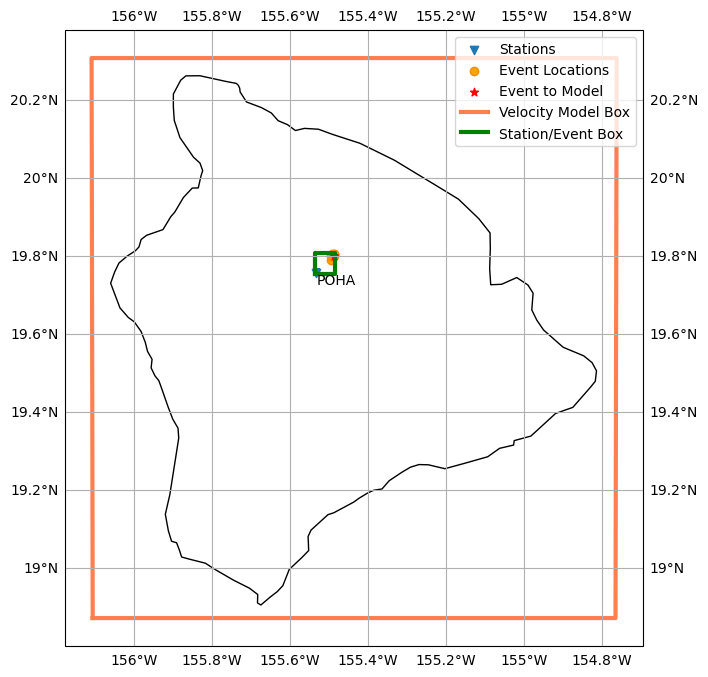

In [17]:
fig=plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(staMD['lon'],staMD['lat'],marker='v',label='Stations')
# Add station labels
[plt.text(i, j, f'{name}',va='top',ha='left') for (i, j,name) in zip(staMD['lon'],staMD['lat'],staMD['name'])]
if multipleEvents:
    plt.scatter(eventLocs['lon'],eventLocs['lat'],marker='o',edgecolors='darkorange',facecolors='orange',label='Event Locations')

plt.scatter(event['lon'],event['lat'],marker='*',facecolors='red',label="Event to Model")
ax.plot(x_vmod, y_vmod, color='coral',lw=3,label='Velocity Model Box')
ax.plot(x_ini, y_ini, color='green',lw=3,label='Station/Event Box')

gl = ax.gridlines(draw_labels=True)


ax.coastlines()
ax.legend(loc='upper right')

plt.show()

# Grid Spacing Math

In [18]:
# This is the relationship from the sw4 manual section 4.5, p 28
# npts should be between 6 and 10

def get_step_size(frequency_max, npts, Vs_min):
    H=Vs_min*1000/(npts*frequency_max)
    return H
    
step_size=get_step_size(freqMax, 10, vs_min)
print(f"Model grid spacing is {step_size} m ")

Model grid spacing is 35.925 m 


Based on the grid spacing, we can now compute the thickeness of the supergrid layer. The supergrid layers are SUPER important because they help damp reflections on the edges of the domain and dramatically decreases the size of the domain you need and decreases computational time. The supergrid points are PART of your model domain. Default number of supergrid points is 30, less than 20 points will make your solution numerically unstable. Long wavelengths are harder to supress than short wavelengths

In [19]:
npts_supergrid=30
supergrid_thickness=step_size*npts_supergrid
supergrid_thickness_deg=np.round(kilometer2degrees(supergrid_thickness/1000),4)
print(f"Do not put event sources or receivers in the outer {supergrid_thickness} m of the domain \nor a buffer of ~{supergrid_thickness_deg} degrees")

Do not put event sources or receivers in the outer 1077.75 m of the domain 
or a buffer of ~0.0097 degrees


We care going to add the width of the supergrid as a buffer around our domain

In [20]:
lonMin=lonMin_ini-supergrid_thickness_deg
lonMax=lonMax_ini+supergrid_thickness_deg
latMin=latMin_ini-supergrid_thickness_deg
latMax=latMax_ini+supergrid_thickness_deg

# setup points for box for domain including supergrid buffer
x=[lonMin,lonMax,lonMax,lonMin,lonMin]
y=[latMin,latMin,latMax,latMax,latMin]

In [21]:
print(latMax)


19.817447249999997


# Some topography calculations

First let's draw a box that is slightly bigger than our x,y domain once we've included the supergrid buffer

In [22]:
# setup points for box for domain for elevation if we do adding the buffer from the elevation_snippet script
buffer=0.05
lonMin_topo=lonMin-buffer
lonMax_topo=lonMax+buffer
latMin_topo=latMin-buffer
latMax_topo=latMax+buffer

# setup points for box for topo domain
x_topo=[lonMin_topo,lonMax_topo,lonMax_topo,lonMin_topo,lonMin_topo]
y_topo=[latMin_topo,latMin_topo,latMax_topo,latMax_topo,latMin_topo]

We need to find the minimum and maximum elevations in our topography to calculate zmax

In [23]:
file2load_topo='maunakea_topo_03s.nc'
# read topo from netcdf
grid_big = xr.open_dataset(file2load_topo)
grid_big

<xarray.Dataset> Size: 11MB
Dimensions:    (lon: 1626, lat: 1731)
Coordinates:
  * lon        (lon) float64 13kB -156.1 -156.1 -156.1 ... -154.8 -154.8 -154.8
  * lat        (lat) float64 14kB 18.87 18.87 18.87 18.87 ... 20.31 20.31 20.31
Data variables:
    elevation  (lat, lon) float32 11MB ...

In [24]:
grid=grid_big.loc[dict(lat=slice(latMin_topo, latMax_topo),lon=slice(lonMin_topo, lonMax_topo))]
grid['elevation'].data.shape

(206, 204)

In [25]:
df_grid = grid.to_dataframe().reset_index().sort_values(['lat', 'lon'])
# df_grid_small=df_grid[(df_grid['lat']<=lat_max+buffer)&(df_grid['lat']>=lat_min-buffer)&(df_grid['lon']<=lon_max+buffer)&(df_grid['lon']>=lon_min-buffer)].reset_index().sort_values(['lat', 'lon'])
elev_max=df_grid['elevation'].max()
elev_min=df_grid['elevation'].min()
lontopo_max=df_grid['lon'].max()
lontopo_min=df_grid['lon'].min()
lattopo_max=df_grid['lat'].max()
lattopo_min=df_grid['lat'].min()
print(f"Minimum elevation is {elev_min} m and the maximum elevation is {elev_max} m")

Minimum elevation is 1754.0 m and the maximum elevation is 4205.0 m


Equation for what to set z_max in the topography command:
egrid ≤ emin − 3(emax − emin), emin ≤ e(x, y) ≤ emax

In [26]:
def calc_topo_zmax(emin,emax):
    egrid=emin-3*(emax-emin)
    zmax=-egrid
    return zmax
z_max=calc_topo_zmax(elev_min,elev_max)
z_max

5599.0

# Revisit Velocity Model

We are going to trim the velocity model to be 0.01 degrees bigger than topography model. This is to allow for the fact that sometimes we end up with a little bigger topography model than we call because of how pygmt pulls it's data.

In [27]:
velocity_buffer=0.01
lonMin_vmod_trim=lonMin_topo-velocity_buffer
lonMax_vmod_trim=lonMax_topo+velocity_buffer
latMin_vmod_trim=latMin_topo-velocity_buffer
latMax_vmod_trim=latMax_topo+velocity_buffer

# setup points for box for topo domain
x_vmod_trim=[lonMin_vmod_trim,lonMax_vmod_trim,lonMax_vmod_trim,lonMin_vmod_trim,lonMin_vmod_trim]
y_vmod_trim=[latMin_vmod_trim,latMin_vmod_trim,latMax_vmod_trim,latMax_vmod_trim,latMin_vmod_trim]

# Add topography to our plot

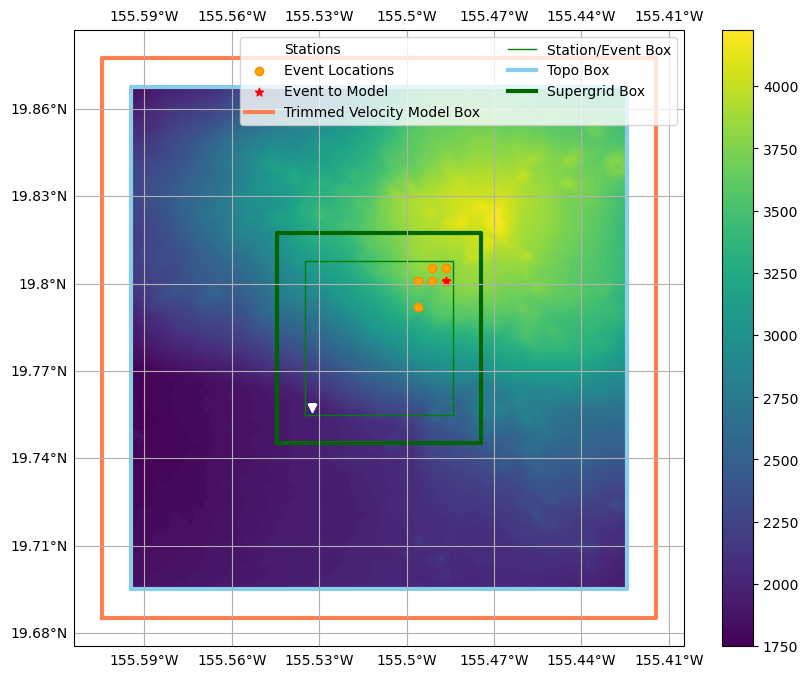

In [28]:
fig=plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(grid.lon, grid.lat,grid.elevation,100)
plt.colorbar()
plt.scatter(staMD['lon'],staMD['lat'],marker='v',facecolors='white',label='Stations')
# Add station labels
# [plt.text(i, j, f'{name}',va='top',ha='left') for (i, j,name) in zip(staMD['lon'],staMD['lat'],staMD['name'])]
if multipleEvents:
    plt.scatter(eventLocs['lon'],eventLocs['lat'],marker='o',edgecolors='darkorange',facecolors='orange',label='Event Locations')

plt.scatter(event['lon'],event['lat'],marker='*',facecolors='red',label="Event to Model")
ax.plot(x_vmod_trim, y_vmod_trim, color='coral',lw=3,label='Trimmed Velocity Model Box')
ax.plot(x_ini, y_ini, color='green',lw=1,label='Station/Event Box')
ax.plot(x_topo, y_topo, color='skyblue',lw=3,label='Topo Box')
ax.plot(x, y, color='darkgreen',lw=3,label='Supergrid Box')
gl = ax.gridlines(draw_labels=True)
gl.right_labels = False

ax.coastlines()

ax.legend(loc='upper right',ncol=2)
plt.show()

# Aggregate Info for .in Files

Some general definitions 

In [29]:
name="maunakeaPOHA"

### Grid Command info

Specifying the coordinates for grid on surface

In [30]:
# Compute cartesian locations for source
X,_,_= gps2dist_azimuth(latMin, lonMin, latMin, lonMax)
Y,_,_= gps2dist_azimuth(latMin, lonMin, latMax, lonMin)
X,Y=np.round(X,-1),np.round(Y,-1)
print(f"x and y in m {X,Y }")
print(f"lat lon of lower left corner {latMin:.3f},{lonMin:.3f}")
print(f"lat lon of upper right corner {latMax:.3f},{lonMax:.3f}")
print(f"Model grid spacing should be at least {step_size:.0f} m for a frequency max of {freqMax} Hz")


x and y in m (7360.0, 8000.0)
lat lon of lower left corner 19.745,-155.545
lat lon of upper right corner 19.817,-155.474
Model grid spacing should be at least 36 m for a frequency max of 4 Hz


/var/folders/gm/n9tndkz53wqc5031zq29976r0000gn/T/ipykernel_9727/947331267.py:2: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  X,_,_= gps2dist_azimuth(latMin, lonMin, latMin, lonMax)
/var/folders/gm/n9tndkz53wqc5031zq29976r0000gn/T/ipykernel_9727/947331267.py:3: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  Y,_,_= gps2dist_azimuth(latMin, lonMin, latMax, lonMin)


For the model depth I'm using the event depth plus a buffer of 2 times the width of the supergrid layer. I made that up

In [31]:
print(f"Maximum depth based on velocity model {depth_max} km")
domainDepth=np.round((np.abs(event['depth']*1000)+2*supergrid_thickness),-3)
print(f"We are using {domainDepth/1000} km as the depth of our model")

Maximum depth based on velocity model 35.0 km
We are using 27.0 km as the depth of our model


In [32]:
grid_cmd=f"grid x={X} y={Y} z={domainDepth} lat={latMin:.3f} lon={lonMin:.3f} az=0 h={step_size:.0f}\n"
print(grid_cmd)

grid x=7360.0 y=8000.0 z=27000.0 lat=19.745 lon=-155.545 az=0 h=36



### Material Model Command Info

In [33]:
sff.generate_pfile(vmod, name, lonMin_vmod_trim, lonMax_vmod_trim, latMin_vmod_trim, latMax_vmod_trim)

In [34]:
pfile_cmd=f"pfile filename={name}.ppmod\n"
print(pfile_cmd)

pfile filename=maunakeaPOHA.ppmod



### Topography Command Info

zmax is the value that sw4 uses for making its curvilinear grid

In [35]:
print(f"zmax is {np.round(z_max,3)}")

zmax is 5599.0


Generate the smaller topography file ending in `.topo` from netcdf file that is the size of the velocity model

In [36]:
sff.write_topo(file2load_topo, name, lonMin_topo, lonMax_topo, latMin_topo, latMax_topo)

In [37]:
topo_cmd=f"topography input=grid file={name}.topo zmax={z_max:.3f} order=3\n"
print(topo_cmd)

topography input=grid file=maunakeaPOHA.topo zmax=5599.000 order=3



### Source Command Info

I'm making numerical green's functions so I run each of the six components of the MT 

In [38]:
sourcetype="Dirac"
moment=1.0
gf_components=["mxx","myy","mzz","mxy","mxz","myz"]
eventLat, eventLon=event['lat'], event['lon']
eventDepth=np.abs(event['depth']*1000)
source_cmd_list=[]
for comp in gf_components:
    src_cmd=f"source lat={eventLat:.3f} lon={eventLon:.3f} depth={eventDepth}  {comp}={moment} type=Dirac t0=0\n"
    source_cmd_list.append(src_cmd)
    print(src_cmd)

source lat=19.801 lon=-155.486 depth=24750.0  mxx=1.0 type=Dirac t0=0

source lat=19.801 lon=-155.486 depth=24750.0  myy=1.0 type=Dirac t0=0

source lat=19.801 lon=-155.486 depth=24750.0  mzz=1.0 type=Dirac t0=0

source lat=19.801 lon=-155.486 depth=24750.0  mxy=1.0 type=Dirac t0=0

source lat=19.801 lon=-155.486 depth=24750.0  mxz=1.0 type=Dirac t0=0

source lat=19.801 lon=-155.486 depth=24750.0  myz=1.0 type=Dirac t0=0



### Receiver Output Command Info

In [39]:
# set output type
out='displacement'

In [40]:
rec_cmd_list=[]
for comp in gf_components:
    rec_cmd=""
    for i in range(len(staMD)):
        rec_cmd=rec_cmd+f"rec lat={staMD['lat'][i]:.3f} lon={staMD['lon'][i]:.3f} depth=0 nsew=1 variables={out} file={staMD['name'][i]}_{comp} usgsformat=1 sacformat=0\n"
    print(rec_cmd)
    rec_cmd_list.append(rec_cmd)

rec lat=19.757 lon=-155.533 depth=0 nsew=1 variables=displacement file=POHA_mxx usgsformat=1 sacformat=0

rec lat=19.757 lon=-155.533 depth=0 nsew=1 variables=displacement file=POHA_myy usgsformat=1 sacformat=0

rec lat=19.757 lon=-155.533 depth=0 nsew=1 variables=displacement file=POHA_mzz usgsformat=1 sacformat=0

rec lat=19.757 lon=-155.533 depth=0 nsew=1 variables=displacement file=POHA_mxy usgsformat=1 sacformat=0

rec lat=19.757 lon=-155.533 depth=0 nsew=1 variables=displacement file=POHA_mxz usgsformat=1 sacformat=0

rec lat=19.757 lon=-155.533 depth=0 nsew=1 variables=displacement file=POHA_myz usgsformat=1 sacformat=0



### Other Command Info

In [41]:
fileio_cmd_list=[]
infilename_list=[]
verbosity=0
for comp in gf_components:
    outdir=name+"_results_"+comp
    fileio_cmd=f"fileio path={outdir} verbose={verbosity}\n"
    print(fileio_cmd)
    fileio_cmd_list.append(fileio_cmd)

    infilename=f"{name}_{comp}.in"
    infilename_list.append(infilename)
    print(infilename)

time_cmd=f"time t=12 \n"

fileio path=maunakeaPOHA_results_mxx verbose=0

maunakeaPOHA_mxx.in
fileio path=maunakeaPOHA_results_myy verbose=0

maunakeaPOHA_myy.in
fileio path=maunakeaPOHA_results_mzz verbose=0

maunakeaPOHA_mzz.in
fileio path=maunakeaPOHA_results_mxy verbose=0

maunakeaPOHA_mxy.in
fileio path=maunakeaPOHA_results_mxz verbose=0

maunakeaPOHA_mxz.in
fileio path=maunakeaPOHA_results_myz verbose=0

maunakeaPOHA_myz.in


# Some last Calculations before making files

### Memory Calculations

Appendix B says roughly 208 bytes/grid point for runs with topography 

BUT "For parallel runs, the memory per grid point will be somewhat higher, because of duplicated
ghost points at the processor boundaries."

In [42]:
grid_pts=(X/step_size)*(Y/step_size)*(domainDepth/step_size)
mem_per_point=208
mem_gb=grid_pts*mem_per_point/1e9
print(f"Rough approximation of memory is {np.round(mem_gb,0)} GB for a maximum frequency of {freqMax} Hz")

Rough approximation of memory is 7.0 GB for a maximum frequency of 4 Hz


### Maximum Grid spacing

To have 30 super grid points on the outside of the domain and at least 60 actual grid points in domain, you can't have a step size for your grid higher than:

In [43]:
h_max=np.min([X/120,Y/120,depth_max*1000/90])
h_max

61.333333333333336

# Write .in file

In [44]:
turn_off_topography = False
if turn_off_topography:
    # this line will comment out the topography command if you need to
    topo_cmd= ("#"+topo_cmd)
for i, fname in enumerate(infilename_list):
    file=open(fname,'w')
    file.write(f"# SW4 input file \n"+
                "# The grid command defines the model domain \n"+
                grid_cmd+
                "# The fileio command specifies output directory and how much text the code spits out while it runs \n"+
                fileio_cmd_list[i]+
                "# The topography reads in the topography model we use \n"+
                topo_cmd+
                "# The pfile command reads the velocity model in \n"+
                pfile_cmd+
                "# the source sets up the event information \n"+
                source_cmd_list[i]+
                "# The time command sets model start time (certain STFs require t0>0 to avoid numerical nonsense) \n"+
                time_cmd+
                "# The rec command set where stations are \n"+
                rec_cmd_list[i])
    file.close()


    